In [1]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils as utils
import transforms as T

In [2]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### PERSO

In [4]:
import json
import numpy as np
  
# Opening JSON file
e = open('data/annotedFire/test/_annotations.coco.json')
f = open('data/annotedFire/train/_annotations.coco.json')
# returns JSON object as 
# a dictionary
data_train = json.load(f)
data_test = json.load(e)

#get image shape
shape_test = []
for id in range(len(data_test["images"])):
    #print("id:",id,", height:",data["images"][id]["height"],", width:",data["images"][id]["width"])
    shape_test.append([data_test["images"][id]["height"],data_test["images"][id]["width"]])

shape_train = []
for id in range(len(data_train["images"])):
    #print("id:",id,", height:",data["images"][id]["height"],", width:",data["images"][id]["width"])
    shape_train.append([data_train["images"][id]["height"],data_train["images"][id]["width"]])


#shape_test = torch.tensor(shape_test).to(device)
#shape_train = torch.tensor(shape_train).to(device)

#get annotations train

local_annotation = []
annotation_train = []
flag = 0

iteration = 0
id = -1

while iteration <= len(data_train["annotations"]):
    
    id += 1
    flag = 0

    while ((flag == 0) & (iteration < len(data_train["annotations"]))):

        if(data_train["annotations"][iteration]["image_id"] == id):
            local_annotation.append(data_train["annotations"][iteration]["bbox"])
            iteration += 1

        else:

            annotation_train.append(local_annotation)
            local_annotation = []
            flag = 1

    if(iteration == len(data_train["annotations"])):
        annotation_train.append(local_annotation)
        local_annotation = []
        iteration += 1

#annotation_train = torch.tensor(annotation_train).to(device)

#get image annotation test

local_annotation = []
annotation_test = []
flag = 0

iteration = 0
id = -1

while iteration <= len(data_test["annotations"]):
    
    id += 1
    flag = 0

    while ((flag == 0) & (iteration < len(data_test["annotations"]))):

        if(data_test["annotations"][iteration]["image_id"] == id):
            local_annotation.append(data_test["annotations"][iteration]["bbox"])
            iteration += 1

        else:

            annotation_test.append(local_annotation)
            local_annotation = []
            flag = 1

    if(iteration == len(data_test["annotations"])):
        annotation_test.append(local_annotation)
        local_annotation = []
        iteration += 1

    
#annotation_test = torch.tensor(annotation_test).to(device)

#Create mask_train
mask_train = []

#initialize array with shape
for i in range(len(data_train["images"])):
    mask_train.append(np.zeros((shape_train[i][0],shape_train[i][1])))

#implement ones
for i in range(len(data_train["images"])):
    instance = 0
    for j in range(len(annotation_train[i])):
        instance += 1
        mask_train[i][annotation_train[i][j][1]:int(annotation_train[i][j][1]+annotation_train[i][j][3]),annotation_train[i][j][0]:int(annotation_train[i][j][0]+annotation_train[i][j][2])] = instance

#mask_train = torch.tensor(mask_train).to(device)

#Create mask_test
mask_test = []

#initialize array with shape
for i in range(len(data_test["images"])):
    mask_test.append(np.zeros((shape_test[i][0],shape_test[i][1])))

#implement ones

for i in range(len(data_test["images"])):
    instance = 0
    for j in range(len(annotation_test[i])):
        instance += 1
        mask_test[i][annotation_test[i][j][1]:int(annotation_test[i][j][1]+annotation_test[i][j][3]),annotation_test[i][j][0]:int(annotation_test[i][j][0]+annotation_test[i][j][2])] = instance


#mask_test = torch.tensor(mask_test).to(device)

In [5]:
len(data_train["images"]),len(annotation_train)

(2621, 2621)

In [6]:
for element in data_train:
    print(element)
    if(element=="images"):
        for subelement in data_train[element]:
            if (subelement["id"] ==62):
                print(subelement)

info
licenses
categories
images
{'id': 62, 'license': 1, 'file_name': 'MirrorWEBFire1056_jpg.rf.3df8d88b9d652ab2641094212f6ae98a.jpg', 'height': 720, 'width': 1280, 'date_captured': '2022-09-28T10:03:57+00:00'}
annotations


In [7]:
data_test["annotations"][1006]

{'id': 1006,
 'image_id': 421,
 'category_id': 1,
 'bbox': [1014, 396, 182, 105],
 'area': 19110,
 'segmentation': [],
 'iscrowd': 0}

In [8]:
data_test["annotations"][1007]

{'id': 1007,
 'image_id': 421,
 'category_id': 1,
 'bbox': [186, 379, 102, 69],
 'area': 7038,
 'segmentation': [],
 'iscrowd': 0}

In [9]:
data_test["annotations"][1008]

{'id': 1008,
 'image_id': 421,
 'category_id': 1,
 'bbox': [48, 8, 1227, 474],
 'area': 581598,
 'segmentation': [],
 'iscrowd': 0}

In [10]:
data_test["annotations"][1009]

{'id': 1009,
 'image_id': 422,
 'category_id': 1,
 'bbox': [373, 502, 37, 38],
 'area': 1406,
 'segmentation': [],
 'iscrowd': 0}

In [11]:
data_train["annotations"][1010]

{'id': 1010,
 'image_id': 406,
 'category_id': 1,
 'bbox': [408, 364, 299, 478],
 'area': 142922,
 'segmentation': [],
 'iscrowd': 0}

In [12]:
data_train["annotations"][1011]

{'id': 1011,
 'image_id': 407,
 'category_id': 1,
 'bbox': [771, 448, 306, 100],
 'area': 30600,
 'segmentation': [],
 'iscrowd': 0}

In [13]:
data_train["annotations"][1006]

{'id': 1006,
 'image_id': 405,
 'category_id': 1,
 'bbox': [784, 499, 135, 44],
 'area': 5940,
 'segmentation': [],
 'iscrowd': 0}

In [14]:
import os
import numpy as np
import torch
from PIL import Image


class FireDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms,train=True):
        self.root = root
        self.transforms = transforms
        self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        list = []
        if self.train:
            for info in data_train["images"]:
                list.append(info["file_name"])
        else:
            for info in data_test["images"]:
                list.append(info["file_name"])

        
        self.imgs = list
        if(self.train):
            self.masks = mask_train
        else:
            self.masks = mask_test

    def __getitem__(self, idx):
        # load images and masks
        
        img_path = os.path.join(self.root, self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array


        mask = np.array(self.masks[idx])

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        #num_objs = len(obj_ids)
        num_objs = len(obj_ids)
        
        boxes = []
        if self.train:

            for box in annotation_train[idx]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])
        else:
            for box in annotation_test[idx]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])

        
        # convert everything into a torch.Tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
import os
import numpy as np
import torch
from PIL import Image


class FireDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms,train=True):
        self.root = root
        self.transforms = transforms
        self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        list = []
        if self.train:
            for info in data_train["images"]:
                list.append(info["file_name"])
        else:
            for info in data_test["images"]:
                list.append(info["file_name"])

        
        self.imgs = list
        if(self.train):
            self.masks = mask_train
        else:
            self.masks = mask_test

    def __getitem__(self, idx):
        # load images and masks
        
        img_path = os.path.join(self.root, self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array


        mask = np.array(self.masks[idx])

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        #num_objs = len(obj_ids)
        num_objs = len(obj_ids)
        
        boxes = []
        if self.train:

            for box in annotation_train[idx]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])
        else:
            for box in annotation_test[idx]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])

        
        # convert everything into a torch.Tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [16]:
obj_ids = np.unique(mask_test[1])
obj_ids = obj_ids[1:]
num_objs = len(obj_ids)


In [17]:
num_objs

2

In [18]:
annotation_test[1]

[[730, 316, 546, 272], [536, 359, 199, 112]]

In [19]:
boxes_train = []

boxes_test = []

for idx in range(30):
    local_boxes_train =[]
    for box in annotation_train[idx]:
        local_boxes_train.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])
    boxes_train.append(local_boxes_train)
for idx in range(20):
    local_boxes_test =[]
    for box in annotation_test[idx]:
        local_boxes_test.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])
    boxes_test.append(local_boxes_test)
    

In [20]:
boxes_test[1]

[[730, 316, 1276, 588], [536, 359, 735, 471]]

In [21]:
boxes_train_i = torch.as_tensor(boxes_train[1], dtype=torch.float32)
boxes_test_i = torch.as_tensor(boxes_test[1], dtype=torch.float32)

In [22]:
area = (boxes_test_i[:, 3] - boxes_test_i[:, 1]) * (boxes_test_i[:, 2] - boxes_test_i[:, 0])

In [23]:
area.tolist()[1]

22288.0

In [24]:
data_test

{'info': {'year': '2022',
  'version': '5',
  'description': 'Exported from roboflow.ai',
  'contributor': '',
  'url': 'https://public.roboflow.ai/object-detection/undefined',
  'date_created': '2022-09-28T10:03:57+00:00'},
 'licenses': [{'id': 1,
   'url': 'https://creativecommons.org/publicdomain/zero/1.0/',
   'name': 'Public Domain'}],
 'categories': [{'id': 0, 'name': 'Fire-and-No-fire', 'supercategory': 'none'},
  {'id': 1, 'name': 'Fire', 'supercategory': 'Fire-and-No-fire'}],
 'images': [{'id': 0,
   'license': 1,
   'file_name': 'WEBFire1910_jpg.rf.9c3c696b01189274bb071581fb87aabc.jpg',
   'height': 922,
   'width': 1846,
   'date_captured': '2022-09-28T10:03:57+00:00'},
  {'id': 1,
   'license': 1,
   'file_name': 'MirrorWEBFire1105_jpg.rf.9e4b3a43f58294f0992c2ff492191c99.jpg',
   'height': 720,
   'width': 1280,
   'date_captured': '2022-09-28T10:03:57+00:00'},
  {'id': 2,
   'license': 1,
   'file_name': 'WEBFire1209_jpg.rf.9b1cca751557d97934680ce500220ea7.jpg',
   'height

In [25]:
baba = torch.ones((22,), dtype=torch.int64)

In [26]:
baba[0]

tensor(1)

In [27]:
a = torch.tensor(1)

In [28]:
a

tensor(1)

In [29]:
import os
import numpy as np
import torch
from PIL import Image


class FireDatasetOver(torch.utils.data.Dataset):
    def __init__(self, root, transforms,train=True):
        self.root = root
        self.transforms = transforms
        self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        list = []
        if self.train:
            for info in data_train["images"]:
                list.append(info["file_name"])
        else:
            for info in data_test["images"]:
                list.append(info["file_name"])

        
        self.imgs = list
        if(self.train):
            self.masks = mask_train
        else:
            self.masks = mask_test

    def __getitem__(self, idx):
        # load images and masks
        
        img_path = os.path.join(self.root, self.imgs[0])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array


        mask = np.array(self.masks[0])

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        #num_objs = len(obj_ids)
        num_objs = len(obj_ids)
        
        boxes = []
        if self.train:

            for box in annotation_train[0]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])
        else:
            for box in annotation_test[0]:
                boxes.append([box[0],box[1],box[0]+box[2],box[1]+box[3]])

        
        # convert everything into a torch.Tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([0])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [30]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [31]:
dataset_train = FireDataset('data/AnnotedFireDataset/train', get_transform(train=True),train = True)
dataset_test = FireDataset('data/AnnotedFireDataset/test', get_transform(train=False), train = False)

dataset_train[0][0]

tensor([[[0.7216, 0.7176, 0.7137,  ..., 0.7059, 0.7059, 0.7020],
         [0.7176, 0.7176, 0.7137,  ..., 0.7098, 0.7059, 0.7059],
         [0.7137, 0.7137, 0.7137,  ..., 0.7098, 0.7137, 0.7137],
         ...,
         [0.2431, 0.2275, 0.2157,  ..., 0.1922, 0.2039, 0.2157],
         [0.2627, 0.2392, 0.2196,  ..., 0.2000, 0.2000, 0.2000],
         [0.2745, 0.2510, 0.2235,  ..., 0.2039, 0.1961, 0.1882]],

        [[0.7451, 0.7412, 0.7373,  ..., 0.7098, 0.7098, 0.7059],
         [0.7412, 0.7412, 0.7373,  ..., 0.7137, 0.7098, 0.7098],
         [0.7373, 0.7373, 0.7373,  ..., 0.7137, 0.7176, 0.7176],
         ...,
         [0.2627, 0.2471, 0.2353,  ..., 0.1843, 0.1961, 0.2078],
         [0.2824, 0.2588, 0.2392,  ..., 0.1922, 0.1922, 0.1922],
         [0.2941, 0.2706, 0.2431,  ..., 0.1961, 0.1882, 0.1804]],

        [[0.8078, 0.8039, 0.8000,  ..., 0.7255, 0.7255, 0.7216],
         [0.8039, 0.8039, 0.8000,  ..., 0.7294, 0.7255, 0.7255],
         [0.8000, 0.8000, 0.8000,  ..., 0.7294, 0.7333, 0.

In [32]:
#Create mask_train
mask_train = []

#initialize array with shape
for i in range(len(data_train["images"])):
    mask_train.append(np.zeros((shape_train[i][0],shape_train[i][1])))

#implement ones
for i in range(len(data_train["images"])):
    instance = 0
    for j in range(len(annotation_train[i])):
        instance += 1
        mask_train[i][annotation_train[i][j][1]:int(annotation_train[i][j][1]+annotation_train[i][j][3]),annotation_train[i][j][0]:int(annotation_train[i][j][0]+annotation_train[i][j][2])] = instance

In [33]:
dataset_train[2][1]["boxes"]

tensor([[2.7800e+02, 8.1000e+01, 7.1300e+02, 4.4100e+02],
        [7.4400e+02, 1.0000e+00, 1.0820e+03, 2.3900e+02]])

In [34]:
annotation_train[2]

[[278, 81, 435, 360], [744, 1, 338, 238]]

In [35]:
data_test["annotations"]

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [390, 398, 1448, 323],
  'area': 467704,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 1,
  'category_id': 1,
  'bbox': [730, 316, 546, 272],
  'area': 148512,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 1,
  'category_id': 1,
  'bbox': [536, 359, 199, 112],
  'area': 22288,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 2,
  'category_id': 1,
  'bbox': [434, 319, 144, 132],
  'area': 19008,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 3,
  'category_id': 1,
  'bbox': [533, 28, 123, 196],
  'area': 24108,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 4,
  'category_id': 1,
  'bbox': [20, 16, 265, 411],
  'area': 108915,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 4,
  'category_id': 1,
  'bbox': [756, 108, 219, 335],
  'area': 73365,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 7,
  'image_id': 5,
  'category_id': 1,

In [36]:
mask_train[0][0].shape

(800,)

In [37]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
#dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

dataset_train = FireDataset('data/AnnotedFireDataset/train', get_transform(train=True),train = True)
dataset_test = FireDataset('data/AnnotedFireDataset/test', get_transform(train=False), train = False)

#dataset = FireDatasetOver('data/AnnotedFireDataset/train', get_transform(train=True),train = True)
#dataset_test = FireDatasetOver('data/AnnotedFireDataset/test', get_transform(train=False), train = False)

subTrainList = list(range(60))
defectsTrain = []
for defect in defectsTrain:
    subTrainList.remove(defect)

subTestList = list(range(15))
defectsTest = []
#defectsTest = [421]
for defect in defectsTest:
    subTestList.remove(defect)

short_dataset_train = torch.utils.data.Subset(dataset_train, subTrainList)
short_dataset_test = torch.utils.data.Subset(dataset_test, subTestList)


#img, target = dataset.__getitem__(0)
#print(img)
#print(target)
#print(type(img), type(target))

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    short_dataset_train, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    short_dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [38]:
dataset_test[0]

(tensor([[[0.2000, 0.2000, 0.2000,  ..., 0.5294, 0.5294, 0.5294],
          [0.2078, 0.2078, 0.2078,  ..., 0.5490, 0.5490, 0.5490],
          [0.2196, 0.2196, 0.2196,  ..., 0.5725, 0.5725, 0.5725],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0549, 0.0549],
          [0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0549, 0.0588],
          [0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0549, 0.0588]],
 
         [[0.2353, 0.2353, 0.2353,  ..., 0.5412, 0.5412, 0.5412],
          [0.2431, 0.2431, 0.2431,  ..., 0.5608, 0.5608, 0.5608],
          [0.2549, 0.2549, 0.2549,  ..., 0.5843, 0.5843, 0.5843],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0549, 0.0549, 0.0549],
          [0.0157, 0.0157, 0.0157,  ..., 0.0549, 0.0549, 0.0588],
          [0.0157, 0.0157, 0.0157,  ..., 0.0549, 0.0549, 0.0588]],
 
         [[0.2157, 0.2157, 0.2157,  ..., 0.5137, 0.5137, 0.5137],
          [0.2235, 0.2235, 0.2235,  ..., 0.5333, 0.5333, 0.5333],
          [0.2353, 0.2353, 0.2353,  ...,

In [39]:
len(dataset_train)

2621

In [40]:
len(dataset_test)

663

In [41]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
print(model)

c:\Users\Calvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Calvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [42]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#print(params)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [43]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1) #20
    print("FINITO")
    # update the learning rate
    lr_scheduler.step()
    print("ensuite")
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/30]  eta: 0:03:15  lr: 0.000177  loss: 2.4647 (2.4647)  loss_classifier: 0.7743 (0.7743)  loss_box_reg: 0.1176 (0.1176)  loss_mask: 1.3862 (1.3862)  loss_objectness: 0.1750 (0.1750)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 6.5212  data: 0.0547  max mem: 2610
Epoch: [0]  [ 1/30]  eta: 0:01:40  lr: 0.000349  loss: 2.4119 (2.4383)  loss_classifier: 0.7518 (0.7630)  loss_box_reg: 0.1176 (0.1352)  loss_mask: 1.3862 (1.4104)  loss_objectness: 0.0640 (0.1195)  loss_rpn_box_reg: 0.0088 (0.0102)  time: 3.4765  data: 0.0571  max mem: 2775
Epoch: [0]  [ 2/30]  eta: 0:01:09  lr: 0.000522  loss: 2.4119 (2.4128)  loss_classifier: 0.7518 (0.7138)  loss_box_reg: 0.1527 (0.2001)  loss_mask: 1.3862 (1.3364)  loss_objectness: 0.1750 (0.1494)  loss_rpn_box_reg: 0.0116 (0.0131)  time: 2.4939  data: 0.0634  max mem: 2775
Epoch: [0]  [ 3/30]  eta: 0:00:53  lr: 0.000694  loss: 2.3617 (2.2463)  loss_classifier: 0.6153 (0.6638)  loss_box_reg: 0.1176 (0.1608)  loss_mask: 1.1886 (1.2657)  loss_ob

In [100]:
##################################
img, _ = dataset_test[233]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

origin_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())


from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img.to(torch.uint8), prediction[0]["boxes"], colors="red")



origin_img.show()
for i in range(1):
    mask_img = Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
    print(np.unique(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
    mask_img.show()
Image.fromarray(drawn_boxes.mul(255).permute(1, 2, 0).byte().numpy()).show()

[  0   1   2   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  59  60  63  64  65  67  68  69  70  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254]


In [45]:
(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()>0).shape

(720, 1280)

In [69]:
resultat_perso = img.clone()
colors = [[255,245,85],[85,245,255],[245,85,255],[233,246,52],[246,52,246],[52,246,181],[181,50,250],[160,80,220],[200,60,160],[170,100,120]]
for k in range(10):
    mask_perso = prediction[0]['masks'][k, 0].mul(255).byte().cpu().numpy()>0
    for i in range(mask_perso.shape[0]):
        for j in range(mask_perso.shape[1]):
            if mask_perso[i,j] == True:
                resultat_perso[0][i,j] = colors[k][0]
                resultat_perso[1][i,j] = colors[k][1]
                resultat_perso[2][i,j] = colors[k][2]

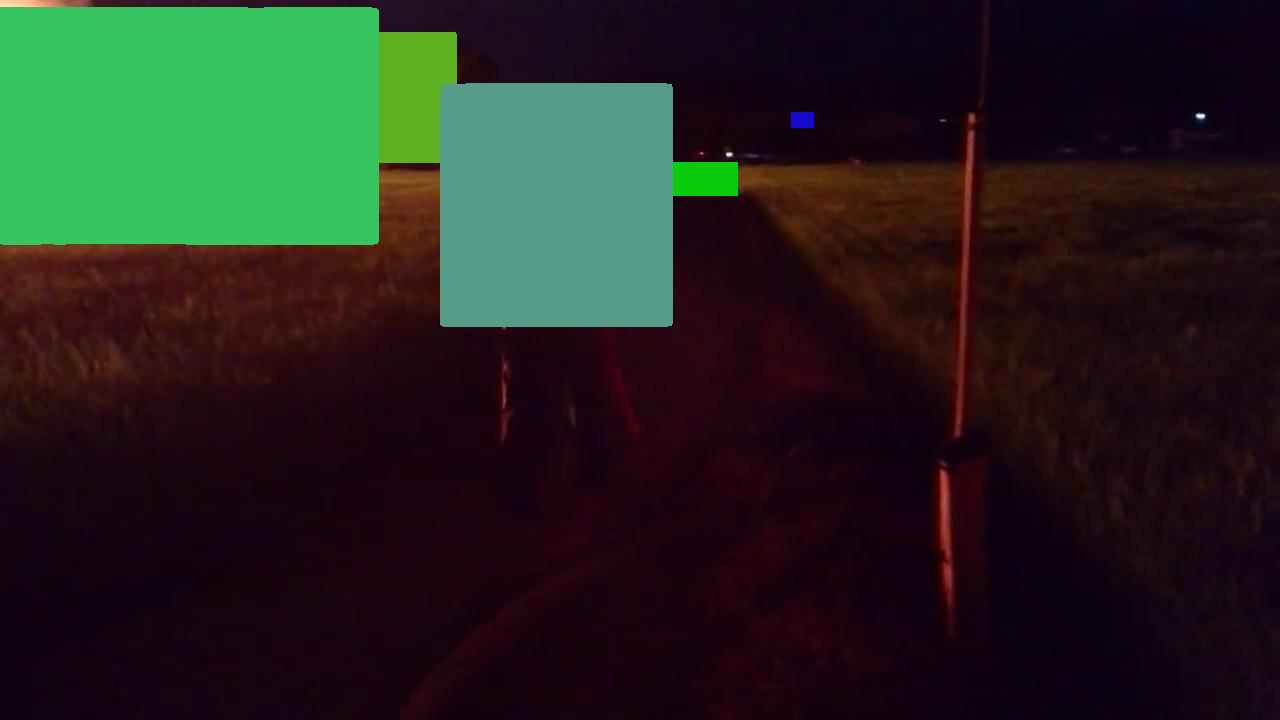

In [70]:
Image.fromarray(resultat_perso.mul(255).permute(1, 2, 0).byte().numpy())

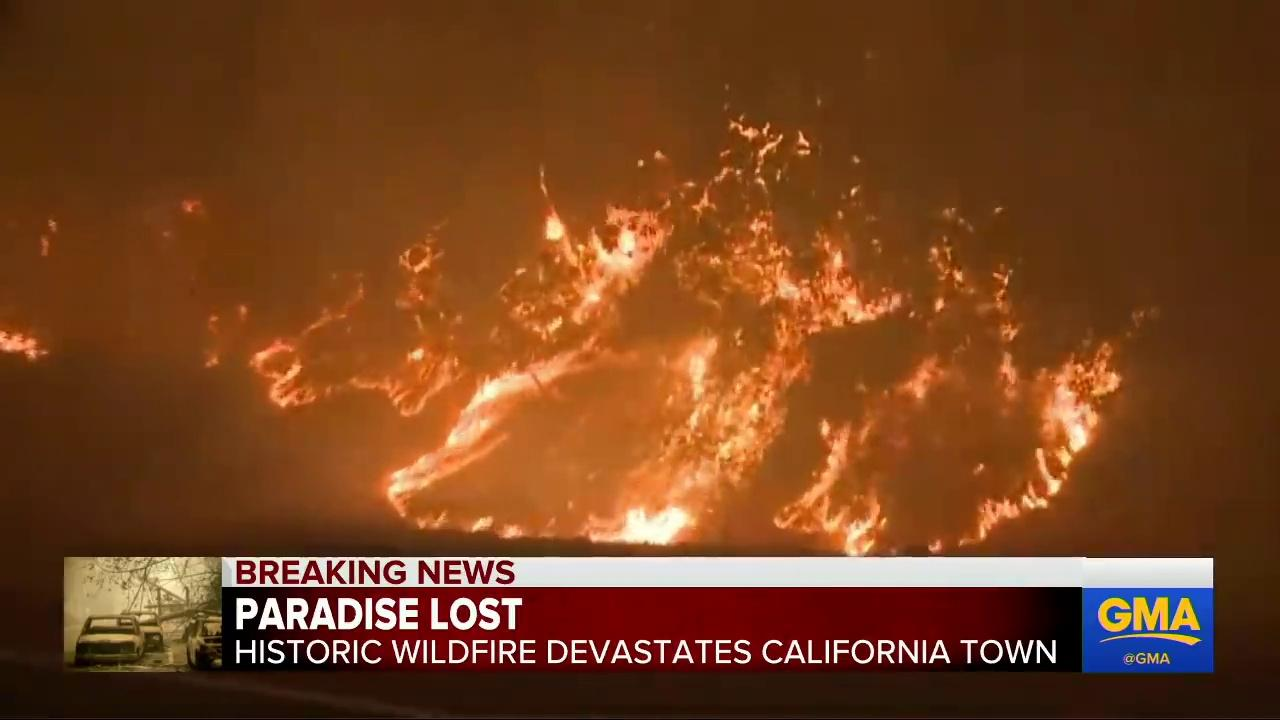

In [48]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [49]:
img.shape

torch.Size([3, 720, 1280])

In [50]:
np.unique(drawn_boxes.mul(255).permute(1, 2, 0).byte().numpy())

array([  0,   1, 255], dtype=uint8)

In [51]:
type(img)

torch.Tensor

In [52]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img.to(torch.uint8), prediction[0]["boxes"], colors="red")
drawn_boxes

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [53]:
Image.fromarray(drawn_boxes.mul(200).permute(1, 2, 0).byte().numpy()).show()

In [54]:
Image.fromarray(drawn_boxes.permute(1, 2, 0).cpu().detach().numpy()).show()

In [55]:
prediction[0]["boxes"]

tensor([[2.5305e+02, 3.3753e+02, 3.1931e+02, 4.1013e+02],
        [5.9193e+02, 4.9921e+02, 6.9782e+02, 5.4347e+02],
        [3.3129e+02, 1.2398e+02, 1.1372e+03, 5.4123e+02],
        [1.0340e+03, 3.3684e+02, 1.1183e+03, 4.9225e+02],
        [4.7505e-01, 3.2723e+02, 4.4549e+01, 3.6004e+02],
        [3.6907e+02, 1.8910e+02, 6.6765e+02, 4.9031e+02],
        [7.7242e+02, 4.1835e+02, 8.8338e+02, 5.4680e+02],
        [5.0127e+02, 4.8411e+01, 8.9909e+02, 5.3861e+02],
        [1.7824e+02, 1.9564e+02, 2.0355e+02, 2.1675e+02],
        [7.7239e+02, 3.4219e+02, 1.1322e+03, 5.2991e+02],
        [5.0624e+02, 1.8266e+02, 6.5961e+02, 3.6337e+02],
        [2.8611e+02, 1.7053e+02, 7.9367e+02, 5.6600e+02],
        [6.0034e+02, 1.2475e+02, 9.5211e+02, 4.7883e+02],
        [2.5121e+02, 2.3040e+02, 5.2299e+02, 4.3933e+02],
        [7.9356e+02, 1.2847e+02, 8.1174e+02, 1.5668e+02],
        [3.8611e+02, 3.6320e+02, 5.2029e+02, 5.1102e+02],
        [4.9690e+02, 5.2245e+02, 5.2954e+02, 5.3905e+02],
        [5.082

In [56]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [57]:
img

tensor([[[0.2078, 0.2039, 0.2039,  ..., 0.2824, 0.2824, 0.2824],
         [0.2078, 0.2039, 0.2039,  ..., 0.2824, 0.2824, 0.2824],
         [0.2078, 0.2039, 0.2039,  ..., 0.2824, 0.2824, 0.2824],
         ...,
         [0.0824, 0.0824, 0.0824,  ..., 0.1255, 0.1255, 0.1255],
         [0.1529, 0.1529, 0.1529,  ..., 0.2431, 0.2431, 0.2431],
         [0.0471, 0.0471, 0.0471,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.0980, 0.0941, 0.0941,  ..., 0.1412, 0.1412, 0.1412],
         [0.0980, 0.0941, 0.0941,  ..., 0.1412, 0.1412, 0.1412],
         [0.0980, 0.0941, 0.0941,  ..., 0.1412, 0.1412, 0.1412],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.0588, 0.0588, 0.0588],
         [0.1098, 0.1098, 0.1098,  ..., 0.1765, 0.1765, 0.1765],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0118, 0.0078, 0.0078,  ..., 0.0471, 0.0471, 0.0471],
         [0.0118, 0.0078, 0.0078,  ..., 0.0471, 0.0471, 0.0471],
         [0.0118, 0.0078, 0.0078,  ..., 0.0471, 0.0471, 0.

In [58]:
numero = 55

img, _ = dataset_test[numero]



In [59]:
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img.to(torch.uint8), prediction[0]["boxes"], colors="red")

show(drawn_boxes)

#Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()).show()

#Image.fromarray(drawn_boxes.mul(200).permute(1, 2, 0).byte().numpy()).show()

In [60]:
np.unique(prediction[0]["masks"][0].cpu()<0.5)

array([False,  True])

In [61]:
print(img.shape)

torch.Size([3, 720, 1280])


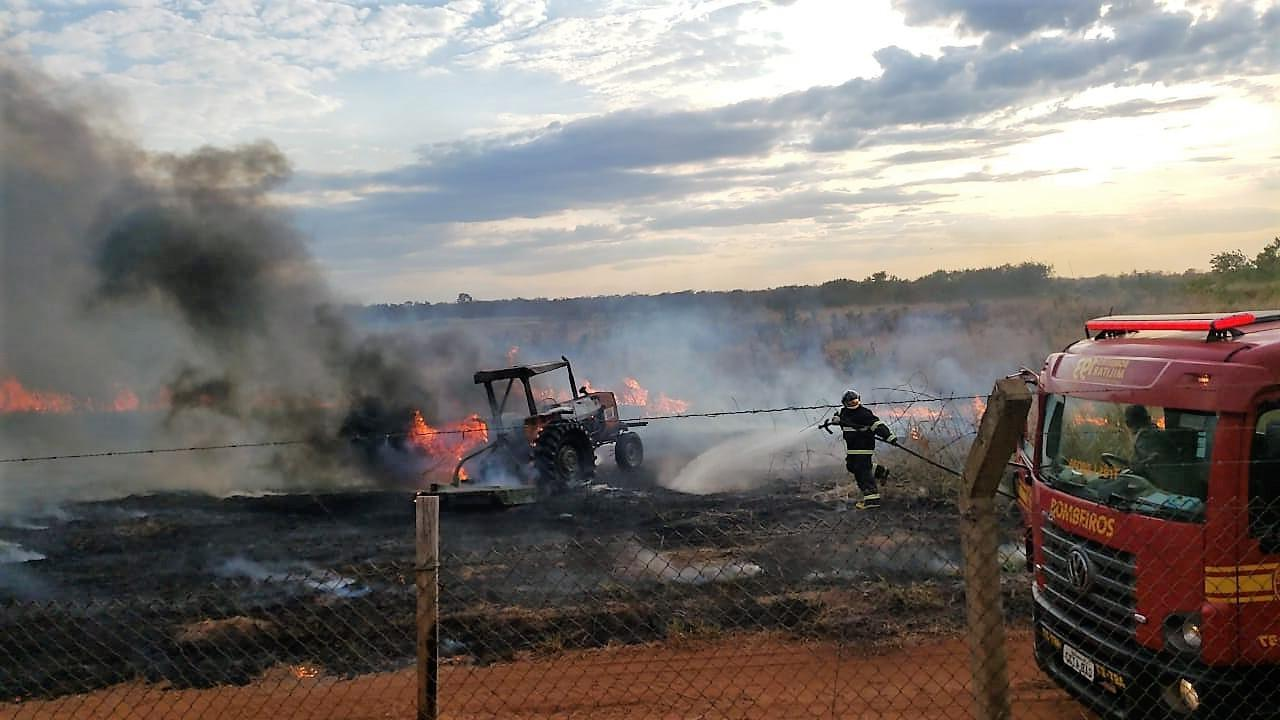

In [62]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [63]:
(prediction[0]["masks"]>0).shape

torch.Size([36, 1, 720, 1280])

In [64]:
np.unique((prediction[0]["masks"][0]>0.5).cpu())

array([False,  True])

In [65]:
img.shape

torch.Size([3, 720, 1280])

In [66]:
(prediction[0]["masks"][i]>0.5)

IndexError: index 719 is out of bounds for dimension 0 with size 36

In [ ]:
from torchvision.utils import draw_segmentation_masks

drawn_masks = []

for i in range(3):
    drawn_masks.append(draw_segmentation_masks(img.to(torch.uint8).cpu(), (prediction[0]["masks"][i]>0.5).cpu(), alpha=0.8, colors="blue"))

#Image.fromarray(np.array(drawn_masks)).show()

show(drawn_masks)

In [ ]:
resultat = draw_segmentation_masks(img.to(torch.uint8).cpu(), (prediction[0]["masks"][0]>0.5).cpu(), alpha=0.8, colors="blue")

In [ ]:
len(resultat)

3

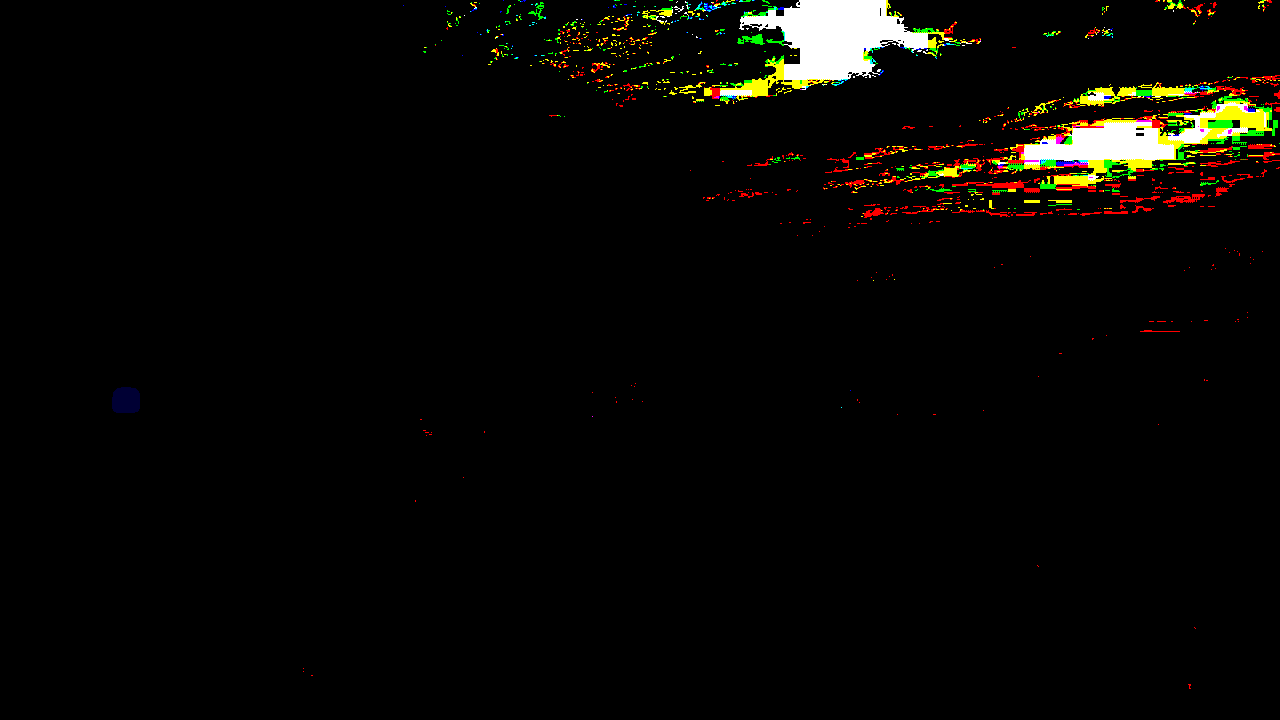

In [ ]:
Image.fromarray(resultat.mul(255).permute(1, 2, 0).numpy())

In [ ]:
fix, axs = plt.subplots(ncols=len(draw_segmentation_masks(img.to(torch.uint8).cpu(), (prediction[0]["masks"][i]>0.5).cpu(), alpha=0.8, colors="blue")), squeeze=False)
for i, img in enumerate(draw_segmentation_masks(img.to(torch.uint8).cpu(), (prediction[0]["masks"][i]>0.5).cpu(), alpha=0.8, colors="blue")):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [ ]:
len(prediction[0]["boxes"].to(int).to(torch.float32))

100

In [ ]:
boxes = prediction[0]["boxes"].to(int).to(torch.float32)[0:3].cpu()

In [ ]:
boxes.shape

torch.Size([6, 4])

In [ ]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img.to(torch.uint8).cpu(), boxes, colors="red")
show(drawn_boxes)

In [ ]:
show(drawn_boxes)

In [ ]:
show(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

ValueError: The image dtype must be uint8, got torch.float32

In [ ]:
draw_segmentation_masks(img.to(torch.uint8), mask, alpha=0.8, colors="blue").shape

torch.Size([3, 720, 1280])

In [ ]:
np.unique(draw_segmentation_masks(img.to(torch.uint8), mask, alpha=0.8, colors="blue"))

array([  0,   1, 204], dtype=uint8)

In [ ]:
from torchvision.utils import draw_segmentation_masks

drawn_masks = []


drawn_masks.append(draw_segmentation_masks(img.to(torch.uint8), (prediction[0]["masks"][0]>0)[0], alpha=0.8, colors="blue"))

#Image.fromarray(np.array(drawn_masks)).show()

In [ ]:
img.to(torch.float32).dtype

torch.float32

In [ ]:
type(img.to(torch.uint8))

torch.Tensor

In [ ]:
img.to(torch.uint8).shape

torch.Size([3, 720, 1280])

In [ ]:
(prediction[0]["masks"][0]>0)[0].shape

torch.Size([720, 1280])

In [ ]:
np.unique((prediction[0]["masks"][0]>0)[0].cpu())

array([False,  True])

In [ ]:
show(drawn_masks)

In [ ]:
for i in range():
    ##################################
    img, _ = dataset_test[i]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    origin_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    mask_img = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

    origin_img.show()
    mask_img.show()

TypeError: range expected at least 1 argument, got 0

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

single = Image.open("pedestrian-tips.jpg")
convert_tensor = transforms.ToTensor()
single = convert_tensor(single)

model.eval()
with torch.no_grad():
    prediction = model([single.to(device)])

origin = Image.fromarray(single.mul(255).permute(1, 2, 0).byte().numpy())
mask = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

origin.show()
mask.show()